In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cuda'):
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
z_dim = 64
image_size = 299
device = 'cuda' # You're not training here, so do this on CPU

In [4]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = CelebA(root=".", download=False, transform=transform)

In [5]:
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f"pretrained_celeba.pth", map_location=torch.device(device))["gen"])
gen = gen.eval()

In [6]:
from torchvision.models import inception_v3
inception_model = inception_v3()
inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode

c:\Users\inven\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


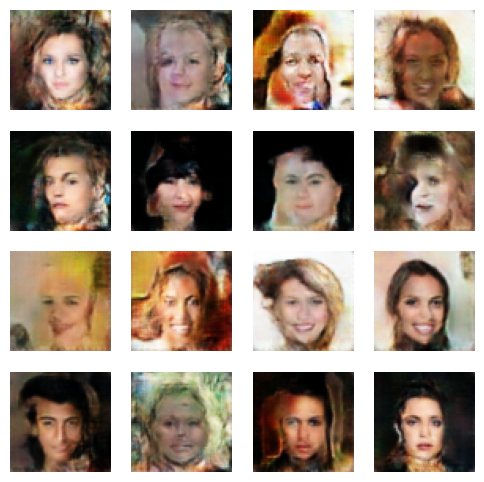

In [7]:
noise = get_noise(16, z_dim)
images = gen(noise)
images = (images + 1)/2
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.axis("off")
    ax.imshow(images[i].detach().cpu().permute(1, 2, 0))

In [8]:
inception_model.fc = nn.Identity()

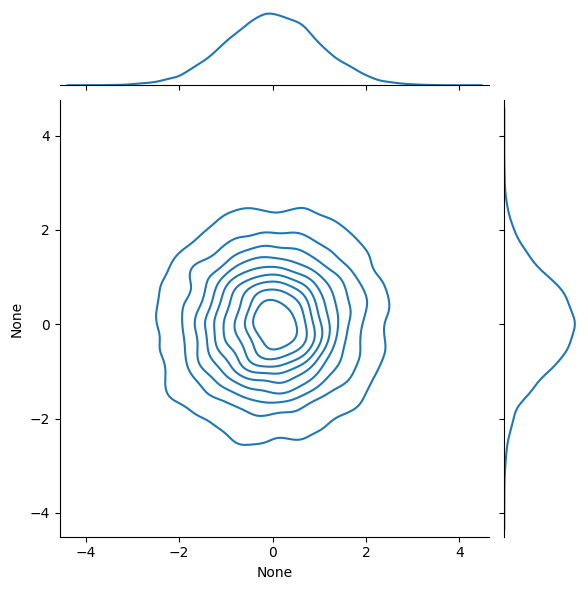

In [12]:
from torch.distributions import MultivariateNormal
import seaborn as sns
mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [[1, 0],
     [0, 1]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000, ))
res = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde")
plt.show()

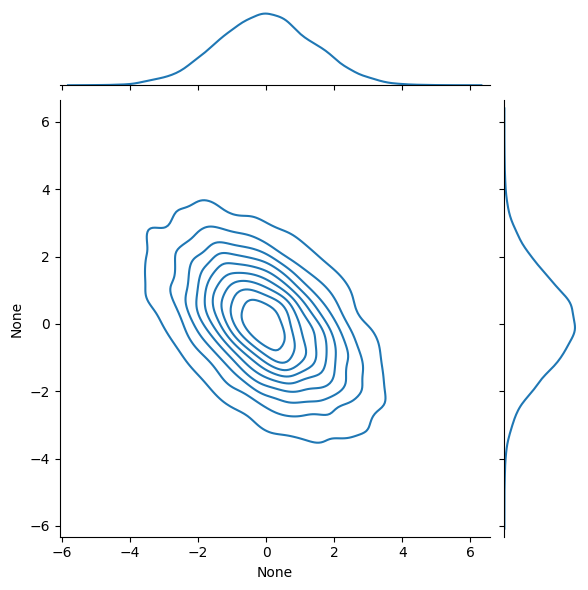

In [21]:
mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [[2, -1],
     [-1, 2]]
)
covariant_dist = MultivariateNormal(mean, covariance)
samples = covariant_dist.sample((10000,))
res = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde")
plt.show()

In [15]:
import scipy
def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [22]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    mean_norm = torch.linalg.vector_norm(mu_x-mu_y)
    trace = torch.trace(sigma_x + sigma_y - 2*matrix_sqrt(sigma_x@sigma_y))
    return mean_norm + trace

In [24]:
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

In [25]:
import numpy as np
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

In [ ]:
fake_features_list = []
real_features_list = []

gen.eval()
n_samples = 512
batch_size = 4

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
cur_samples = 0
with torch.no_grad():
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples//batch_size):
            real_samples = real_example
            real_features = inception_model(real_samples.to(device)).detach().to("cpu")
            real_features_list.append(real_features)

            fake_samples = get_noise(len(real_example), z_dim).to(device)
            fake_samples = preprocess(gen(fake_samples))
            fake_features = inception_model(fake_samples.to(device)).detach().to("cpu")
            fake_features_list.append(fake_features)
            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break
    except:
        print("Error in Loop")

In [32]:
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

In [34]:
print(fake_features_all.shape)
print(real_features_all.shape)

torch.Size([512, 2048])
torch.Size([512, 2048])


In [37]:
mu_fake = torch.mean(fake_features_all, dim=0)
mu_real = torch.mean(real_features_all, dim=0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

In [39]:
print(mu_fake.shape)
print(sigma_fake.shape)

torch.Size([2048])
torch.Size([2048, 2048])


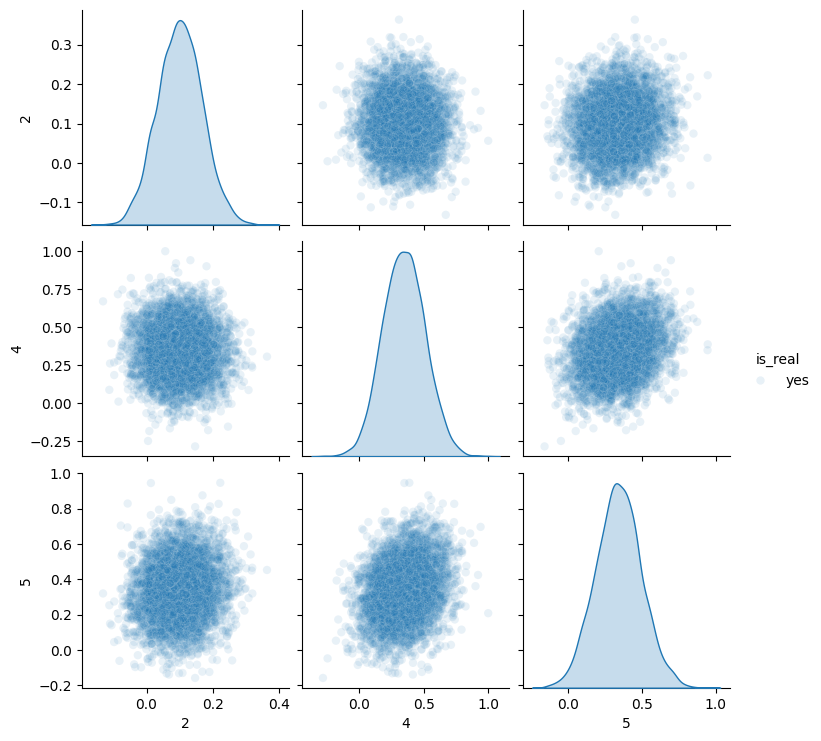

In [49]:
indices = [2, 4, 5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

import pandas as pd
df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_fake["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')

In [50]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

88.57571411132812
